# Instacart Grocery Orders Analysis

Details of the project can be found on the Kaggle page here: https://www.kaggle.com/c/instacart-market-basket-analysis

#### Description

>*Whether you shop from meticulously planned grocery lists or let whimsy guide your grazing, our unique food rituals define who we are. Instacart, a grocery ordering and delivery app, aims to make it easy to fill your refrigerator and pantry with your personal favorites and staples when you need them. After selecting products through the Instacart app, personal shoppers review your order and do the in-store shopping and delivery for you.*
>
>*Instacart’s data science team plays a big part in providing this delightful shopping experience. Currently they use transactional data to develop models that predict which products a user will buy again, try for the first time, or add to their cart next during a session. Recently, Instacart open sourced this data - see their blog post on 3 Million Instacart Orders, Open Sourced.*
>
>*In this competition, Instacart is challenging the Kaggle community to use this anonymized data on customer orders over time to predict which previously purchased products will be in a user’s next order.*


The original project, as described on Kaggle, is about using the order data (i.e. set of products purchased and meta data) of the customers to predict their next order. My goal behind this project is to explore a bayesian predicting model I have been thinking of lately. 

Specifically, I am trying to answer the following question:
**How does a *simple* bayesian model that uses only the order history of the customer perform?** 

There are a couple of things I need to explain about the above statement. 
1. The model is *simple* in the sense that it discards most of the secondary information like at what time of the day or what day of the week the order was made. I am implicitly assuming that these parameters don't play any role. Of course, that need not be true.
2. The model is bayesian, i.e. for each customer we compute a posterior distribution and the products predicted are simply a sample from this distribution.

The description of the data and the goal of the orginal project is given in detail on the project website https://www.kaggle.com/c/instacart-market-basket-analysis

I have divided this noteboook into three major parts:

1. Some basic exploratory analysis to get a feel for the data.
2. A first naive approach
3. Drawing lessons from this naive approach and design of the improved solution.

### Part 1:

Let's start with some basic exploratory analysis. The first graph shown below is self-explanatory. Important is to notice that a large fraction of users have ordered less than 10 times. 

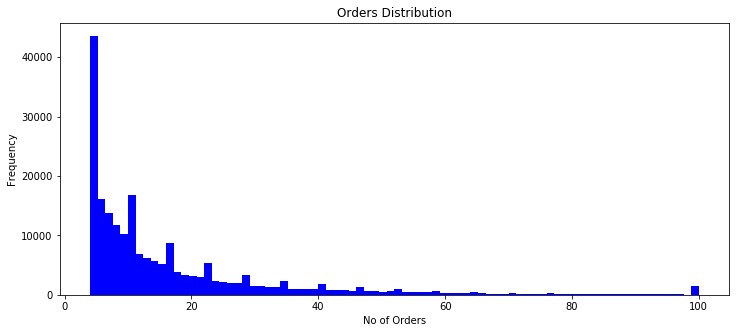

In [8]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 5]
import pandas as pd

"""
Plot for Orders Distribution.
"""
data = pd.DataFrame()
data = pd.read_csv('Data/orders.csv').loc[:, ['order_id', 'user_id']]

distr = data.groupby('user_id').count()

plt.hist(distr.loc[:, 'order_id'].values, bins=80, color='b')
plt.xlabel('No of Orders')
plt.ylabel('Frequency')
plt.title('Orders Distribution')
plt.show()

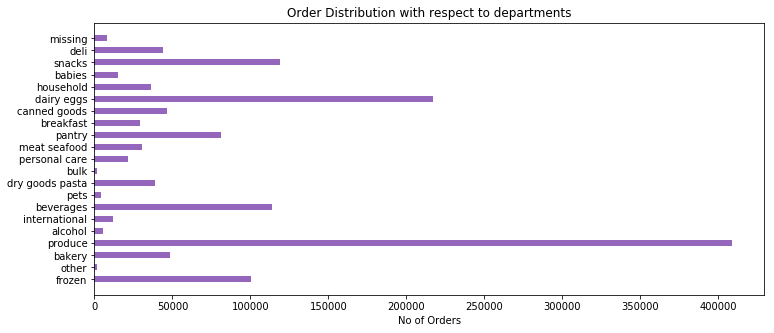

In [9]:
import numpy as np
"""
Plot for order distribution with respect to department
"""

order_product = pd.read_csv('Data/order_products__train.csv').loc[:, ['order_id', 'product_id']]
products = pd.read_csv('Data/products.csv').loc[:, ['product_id', 'department_id']]
depts = pd.read_csv('Data/departments.csv')

merged = pd.merge(order_product, products)
merged = merged.loc[:, ['order_id', 'department_id']]
# print merged.head(20)

merged_distr = merged.groupby('department_id').count()

x = np.arange(21)
plt.barh(x, merged_distr.loc[:, 'order_id'].values, 0.5, fc='tab:purple')
plt.yticks(x ,depts.loc[:, 'department'], rotation='horizontal')
plt.xlabel('No of Orders')
plt.title('Order Distribution with respect to departments')
plt.show()

### Part 2:


## The Objective

Instacart's business model revolves around making grocery shopping fast and efficient. With this in view, they envision a service that predicts what is it that you'd order based on your purchasing history. More specifically, we want to design a system that comes up with a grocery order such that it is *close* to the actual order made by the customer.

## The high level Idea

As a first attempt, I am computing a posterior probability distribution over the *departments* to which the products belong. This is achieved by means of a beta distribution. To give a concrete example, suppose we have a biased coin with some unknown probability p of showing heads. Suppose further, that the coinn is tossed n times, of which k times heads shows up. The posterior distribution of the probability p is given by
$$
p(x; \alpha, \beta) ~=~ \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) \Gamma(\beta)}~ x^{\alpha-1} x^{\beta - 1}$$

In [7]:
%matplotlib inline

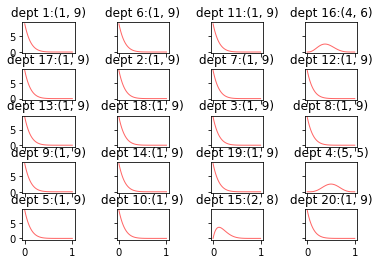

In [11]:
from scipy.stats import beta
import pandas as pd
import numpy as np

# Read the data in DataFrames
order_products_train = pd.read_csv('Data/order_products__train.csv').loc[
    :, ['order_id', 'product_id']]
products = pd.read_csv('Data/products.csv').loc[
    :, ['product_id', 'department_id']]
orders = pd.read_csv('Data/orders.csv').loc[:, ['order_id', 'user_id']]

# Compact holds the entire data in the form: ('user_id','department_id')
compact = pd.merge(order_products_train, products)
compact = pd.merge(compact, orders)
compact = compact.loc[:, ['user_id', 'department_id']]


# Approach based on beta distribution
distr_base = {}
user_list = compact.loc[:, 'user_id'].unique()
first_user = list()
first_user.append(user_list[0])

# Here I am using only one consumer to represent how the 
# probability distributions for departments look like.

for user_id in first_user:
    temp = compact.loc[compact['user_id'] == user_id, 'department_id']
    no_of_orders = len(temp.values)
    
    if user_id not in distr_base:
        distr_base[user_id] = np.ones((21, 2))

    user_distr = distr_base[user_id]
    for dept_id in temp.values:
        user_distr[dept_id-1][0] += 1

    for dept_id in xrange(0, 21):
        user_distr[dept_id][1] += no_of_orders - user_distr[dept_id][0] + 1

    # print user_distr

    fig, ax = plt.subplots(5, 4, sharex='col', sharey='row')
    i = j = 0
    for dept_id in xrange(0, 20):
        a = user_distr[dept_id][0]
        b = user_distr[dept_id][1]
        
        # x = np.linspace(beta.ppf(0.001, a, b), beta.ppf(0.999, a, b), 100)
        x = np.linspace(0.0, 1.0, 100)
        ax[i, j].plot(x, beta.pdf(x, a, b), 'r-', lw=1, alpha=0.6)
        ax[i, j].set_title('dept %d:(%d, %d)' % (dept_id+1, a, b))

        i = (i+1) % 5
        j = (j+1) % 4

    fig.subplots_adjust(hspace=0.5, wspace=0.8)
    plt.show()


Okay, let's be a bit more systematic about this and define some concrete structures. In the rest of the notebook, I'll be using the following class definition.

In [ ]:
class User:
    def __init__(self, user_id):
        self.user_id = user_id
        
        # this holds the beta distribution parameters
        # for dept distribution
        self.dept_distr = np.ones((21, 2))
        
        # this is a dictionary of the form: dept => prod_distr
        self.product_list = [dict() for x in range(21)]

The idea here is to develop a two level structure for predicton. First of all, we encapsulate all the information associated with a consumer in a object defined by the class above. This object can be accessed using a dictionary with user_id as the key.

For any such consumer, we maintain 20 distributions associated with the corresponding departments (we are actually just maintaining the alpha, beta values). These distributions capture the likelihood that the consumer would buy *something* from the department based on the buying history.

Next, for each of the departments, we maintain $K$ distributions associated with each of the $K$ products. *Given that the consumer buys something from this department, this distributions capture the likelihood of a product being bought.* Hence, these are **conditional probabilities**. Training this method therefore involves computation of department and product distributions for **each** customer.

As part of testing, we predict a new order from an existing customer as follows: 
1. Locate the user in dictionary. Draw one value from each of the department distributions. If the value drawn is greater than 0.5, it is understood that the buyer will buy something from the department.
2. For each such department, draw values from each of the product distributions. If the value is greater than 0.5 (actually, we could use a different threshold as well) we add the product to our predicted set.

In [ ]:
# user_dict maps user_id to its corresponding object
user_dict = dict()

for user_id in compact.loc[:, 'user_id'].unique():
    print 'user_id:', user_id
    temp = compact.loc[compact['user_id'] == user_id, ['department_id', 'product_id']]
    no_of_orders = temp.shape[0]
    # print no_of_orders,

    if user_id not in user_dict:
        user_dict[user_id] = User(user_id)

    user_obj = user_dict[user_id]
    for dept_id in temp.loc[:, 'department_id'].values:
        user_obj.dept_distr[dept_id-1][0] += 1

    for dept_id in xrange(0, 21):
        user_obj.dept_distr[dept_id][1] += no_of_orders - user_obj.dept_distr[dept_id][0] + 1

        # compute the alpha beta parameters also for the individual products in a dept
        # print 'dept_id:', dept_id
        product_info = temp.loc[temp['department_id'] == dept_id, 'product_id']
        no_of_product_orders = product_info.shape[0]
        # print no_of_product_orders

        for prod_id in product_info.values:
            if prod_id not in user_obj.product_list[dept_id]:
                user_obj.product_list[dept_id][prod_id] = np.ones(2)

            user_obj.product_list[dept_id][prod_id][0] += 1

        for prod_id in user_obj.product_list[dept_id]:
            user_obj.product_list[dept_id][prod_id][1] += \
                no_of_product_orders - user_obj.product_list[dept_id][prod_id][0] + 1

### One Practical Difficulty

Before proceeding, there is one more thing I need to mention. The above described code to construct user dictionaries runs literally forever on the actual data set, i.e. order_products__prior.csv. Given the limitations of the machine I have at hand, the only way to work further is to make the data set smaller. I do this, by focusing on users who have at least 99 orders; there are about 1374 such users and 136026 corresponding orders. The code for trimming the data set is given below:


In [ ]:
data = pd.read_csv('Data/orders.csv')
data = data.loc[data['eval_set'] == 'prior', ['order_id', 'user_id']]

distr = data.groupby('user_id').count()
# print distr, distr['order_id'].values, distr.index.values
trimmed_data = pd.DataFrame(
    {'order_count': distr['order_id'].values, 'user_id': distr.index.values})

high_order_users = trimmed_data.loc[
    trimmed_data['order_count'] >= 99, 'user_id'].values
print len(high_order_users)

high_order_data = data.loc[data['user_id'].isin(high_order_users)]
print high_order_data.shape

order_products_prior = pd.read_csv('Data/order_products__prior.csv').loc[
    :, ['order_id', 'product_id']]
order_products_skimmed = order_products_prior.loc[
    order_products_prior['order_id'].isin(high_order_data['order_id'].values)]
# print order_products_skimmed.shape
# order_products_skimmed.to_csv('Data/order_products__skimmed.csv')


# split order_products_skimmed into training and testing sets
compl_order_list = order_products_skimmed['order_id'].unique()
no_of_orders = len(compl_order_list)

# draw 2000 random indices for orders
rand_set = random.sample(xrange(no_of_orders), 2000)

# separating orders based on the random sample of indices generated above
testOrders = [compl_order_list[index] for index in rand_set]
trainOrders = [compl_order_list[index] for index in range(len(compl_order_list)) if index not in rand_set]
print len(trainOrders)

order_products_skimmed_test = order_products_skimmed.loc[order_products_skimmed['order_id'].isin(testOrders)]
order_products_skimmed_test.to_csv('Data/order_products__skimmed_test.csv')

order_products_skimmed_train = order_products_skimmed.loc[order_products_skimmed['order_id'].isin(trainOrders)]
order_products_skimmed_train.to_csv('Data/order_products__skimmed_train.csv')

To efficiently work with the test data, I am storing it in a separate data structure of the form: [ order_id, user_id, [list of products] ]

In [ ]:
def createTestList():
    """
    Creates a data structure to iterate over the test orders.
    These orders are stored in a list of the form: [ order_id, user_id, [list of products] ]

    :return: testList data structure
    """
    print 'Creating testList'

    order_products_test = pd.read_csv(
        'Data/order_products__skimmed_test.csv').loc[:, ['order_id', 'product_id']]
    orders = pd.read_csv('Data/orders.csv')
    orders_test = orders.loc[
        orders['eval_set'] == 'prior', ['order_id', 'user_id']].reset_index()

    testList = list()

    for order_id in order_products_test.loc[:, 'order_id'].unique():
        orderList = list()
        orderList.append(order_id)
        # print orderList

        user_id = orders_test.loc[
            orders_test['order_id'] == order_id, 'user_id'].values[0]
        orderList.append(user_id)
        # print orderList

        temp = order_products_test.loc[
                order_products_test['order_id'] == order_id, 'product_id'
                ].values
        orderList.append(temp)
        # print orderList

        testList.append(orderList)

    return testList


Finally, we only need the code to actually predict the order contents of an user in the test set. 

In [ ]:
def predictions(testList, user_dict):
        """
        uses user_dict to make predictions about the set of items 
        bought for each order in testList. It is important to note here 
        that the threshold of 0.5 for dept_prob and prod_prob is a 
        parameter. Change this to fine tune the algorithm behaviour.
        
        :param testList: data structure containing the test set
        :param user_dict: data structure created as part of training
        """

        print 'In predictions...'
        # loop over all orders in testList
        i=0
        accuracy = 0.0
        for order in testList:
            # pred_list is the list of products predicted by the algorithm
            pred_list = list()
            user_id = order[1]
            print user_id

            if user_id not in user_dict:
                print "New User!?"
                exit(1)

            user_obj = user_dict[user_id]
            for dept_id in xrange(0, 21):
                a = user_obj.dept_distr[dept_id][0]
                b = user_obj.dept_distr[dept_id][1]
                if a <= 0.0 or b <= 0.0:
                    print "dept_id: error", a, b
                    exit(1)

                # draw a value from the distribution for department dept_id
                dept_prob = beta.rvs(a, b)
                print 'dept_prob: ', dept_id, dept_prob
                
                # continue to product distributions if 
                # probability of choosing the department is >=0.1
                if dept_prob >= 0.10:
                    for prod_id, distr_para in user_obj.product_list[dept_id].iteritems():
                        a = user_obj.product_list[dept_id][prod_id][0]
                        b = user_obj.product_list[dept_id][prod_id][1]
                        if a <= 0.0 or b <= 0.0:
                            print "prod_id: error", a, b
                            exit(1)
                        prod_prob = beta.rvs(a, b)
                        print 'prod_prob: ', prod_id, prod_prob
                        # if prob of choosing a product greater than 0.1,
                        # add it to predicted list
                        if prod_prob >= 0.10:
                            pred_list.append(prod_id)

            print pred_list, order[2]
            correct_predictions = np.intersect1d(pred_list, order[2])
            print correct_predictions
            accuracy += float(len(correct_predictions)) / len(order[2])
            
        print 'Average accuracy:', accuracy / len(testList)

### Part 3

### Observations

First of all, the core idea here is to use a probabilistic model to predict users' order contents based *only* on the history of the given user, i.e. this model does not consider associations between different products observed across all users. The hope is that with enough data (each user here has 99 orders!) we should be able to learn the user's preferences using a simpler model.

** The current approach is however not working as expected**. The predicted average accuracy was less than 5% for the parameter as chosen above. Clearly, we need more sophisticated techniques for choosing the parameters.


#### Improvement Ideas:

1. One of the major problems with the above described idea is that there is no clear handle on *how many products would a customer buy for a given order*. In the improved version described below, I simply use the expected / average number of products bought by *each* customer. Not just that, since we use a bayesian approach to choosing departments and the subsequent products, we also need to maintain *the expected number of products bought by a customer from a given department*. To record this information in a clean manner, we shall maintain corresponding fields in the user object itself.


In [1]:
class User:
    def __init__(self, user_id):
        self.user_id = user_id
        # this holds the beta distribution parameters
        # for dept distribution
        self.dept_distr = np.ones((22, 2))

        # this denotes the average number of different departments the user shops from
        self.avg_num_of_unique_depts = 0
        # this denotes the average number of products bought from each dept
        self.avg_num_of_products_per_dept = np.zeros(22)
        # this is a dictionary of the form: dept => prod_distr
        self.product_list = [dict() for x in range(22)]

2. Instead of considering each department in isolation when deciding whether to pick it or not, we draw departments from a joint distribution described by a probability vector over the 22 departments. This probability vector is constructed as below:

In [ ]:
user_obj = user_dict[user_id]
dept_prob = np.zeros(22)
for dept_id in xrange(1, 22):
    a = user_obj.dept_distr[dept_id][0]
    b = user_obj.dept_distr[dept_id][1]
    if a <= 0.0 or b <= 0.0:
        print "dept_id: error", a, b
        exit(1)

    # draw a value from the distribution for department dept_id
    dept_prob[dept_id] = beta.rvs(a, b)

norm_dept_prob = [dept_prob[dept_id] / sum(dept_prob) for dept_id in xrange(1, 22)]

3. The *norm_dept_prob* list simply normalizes the dept_prob values so that the resulting list represents a distribution. The advantage of this approach is that in cases where the probability of choosing a department is low, say 0.2-0.3, but the probabilities of other departments are much lower, then the normalized distribution correctly captures the relative importance of a department. Further more, we don't need to use arbitrary parameters like 0.5 to decide if a department should be in the predicted list or not.

With this in hand, we draw *samples* from this distribution *without replacement*.

``pred_dept_list = np.random.choice(21, int(math.ceil(user_obj.avg_num_of_unique_depts))+2, replace=False, p=norm_dept_prob)``


This same idea is also used for products within each department.


In [ ]:
        for dept_id in pred_dept_list:
            prod_prob = dict()
            for prod_id, distr_para in user_obj.product_list[dept_id].iteritems():
                a = user_obj.product_list[dept_id][prod_id][0]
                b = user_obj.product_list[dept_id][prod_id][1]
                if a <= 0.0 or b <= 0.0:
                    print "prod_id: error", a, b
                    exit(1)
                prod_prob[prod_id] = beta.rvs(a, b)

            # print 'prod_prob: ', prod_prob
            # if prod_prob dictionary is not empty
            if prod_prob:
                norm_prod_prob = dict()
                for prod_id, rand_var in prod_prob.iteritems():
                    norm_prod_prob[prod_id] = prod_prob[prod_id] / sum(prod_prob.values())

                # print norm_prod_prob
                # print 'norm_prod_prob.keys(): ', norm_prod_prob.keys()
                # print 'norm_prod_prob.values(): ', norm_prod_prob.values()

                pred_prod_list = list(
                    np.random.choice(norm_prod_prob.keys(),
                    min(int(math.ceil(user_obj.avg_num_of_products_per_dept[dept_id]))+1, len(norm_prod_prob.keys())),
                    replace=False, p=norm_prod_prob.values()))
            else:
                pred_prod_list = list()
                pred_prod_list.append('None')

            pred_list.extend(pred_prod_list)

With these rather simple improvements, **I am getting an average accuracy in the range of 16-21%**(depending on the heuristic described below). I should also point out here that while predicting, I am always choosing ``int(math.ceil(user_obj.avg_num_of_unique_depts)) + 2`` departments and ``min(int(math.ceil(user_obj.avg_num_of_products_per_dept[dept_id])) + 1, len(norm_prod_prob.keys()))`` products. This is just a heuristic that seems to work satisfactorily. As of now, I am not sure if there is a better way of choosing these parameters.

Furthermore, we also need to ensure that the obtained accuracy is meaningful. For example, if I dump the complete product list as my prediction, I am guaranteed to get 100% accuracy. It is also important that a high percentage of predicted items are bought. This is computed as follows:

In [ ]:
# pred_list: list of predicted products
# order[2]: list of items actually bought in a given order

correct_predictions = np.intersect1d(pred_list, order[2])
print 'correct_predictions', correct_predictions
accuracy += float(len(correct_predictions)) / len(order[2])
accuracy_vol += float(len(correct_predictions)) / len(pred_list)
  
print 'Average accuracy:', accuracy / len(testList)
# fraction of predicted products bought 
print 'Average accuracy by volume:', accuracy_vol / len(testList) 

Unfortunately, this second benchmark for accuracy is around 7-8% for the current solution, i.e. only 8% of the products that I predict, the customer actually buys, whereas 20% of the products bought by a customer are in my prediction list.

I think 25% for both benchmarks is something that might be possible to achieve. 